In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from local.lib.utils import forceNamingConvention

In [2]:
def load(variable: str, at_time: int) -> dict:

    '''
    Opens all netcdfs for a given variable and extracts the 2-d spatial data at a given time value. Returns
    a list of DataArrays which can then be further manipulated, e.g. to find the ensemble mean.

    inputs:
     - variable: the variable name, e.g. thickness
     - at_time: the simulation time to plot (30 for first timestep and 9990 for last timestep)

    output:
     - data: a list of xarray DataArrays, with each element being one run in the ensemble. 
    '''

    path = Path('/Users/jonniebarnsley/data/pliocene')
    arrays = {}
    variable_dir = path / variable
    files = sorted(variable_dir.iterdir())

    for file in files:
        
        # ignore hidden files if they exist
        if file.name.startswith('.'):
            continue

        dataset = forceNamingConvention(xr.open_dataset(file, engine='netcdf4'))
        array = dataset[variable]
        try:
            array_at_time_t = array.sel(time=at_time).drop_vars('time') # select time and drop time variable from dataarray
            arrays[file.name] = array_at_time_t
        except KeyError:
            print(f'{file.name} has no time coordinate {at_time}. continuing...')
            continue
    
    return arrays

In [3]:
dthk_arrays = [] # list to store thickness change data

init_thk = load('thickness', at_time=30) # initial thickness for each run
final_thk = load('thickness', at_time=9990) # final thickness for each run

# iterate over runs
for filename, final in final_thk.items():
    init = init_thk[filename]
    change_in_thk = final.fillna(0)-init.fillna(0) # fill NaN with 0 to prevent issues (e.g. NaN - float = NaN)
    dthk_arrays.append(change_in_thk)

# concatenate all dataarrays into one big dataarray so we can take the mean and std using xarray's built in methods
dthk = xr.concat(dthk_arrays, dim='run')
mean = dthk.mean(dim='run')
std = dthk.std(dim='run')

# put nans back in for nicer plotting
ensemble_mean_thickness_change = mean.where(mean != 0)
ensemble_std_thickness_change = std.where(std > 0)

Pliocene_run048_cesm_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...


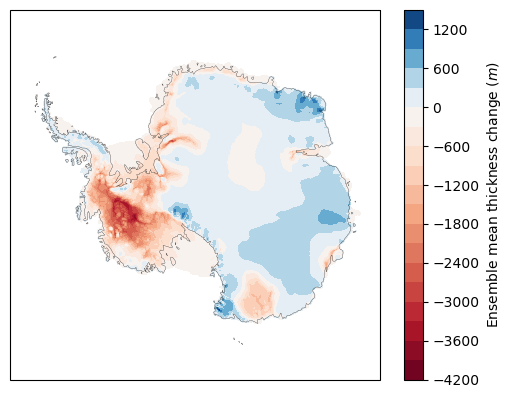

In [10]:
# quick plot to take a look
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})

# centre on South Pole
x = ensemble_mean_thickness_change.x
y = ensemble_mean_thickness_change.y
x = x - x.mean()
y = y - y.mean()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
    

im = ax.contourf(x, y, ensemble_mean_thickness_change, 20, norm=mpl.colors.TwoSlopeNorm(0), \
                 transform = ccrs.Stereographic(**kw), cmap='RdBu')
ax.coastlines(lw=0.2)
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, extend='both', label='Ensemble mean thickness change ($m$)')

plt.savefig('/Users/jonniebarnsley/Downloads/pliocene_mean_thickness_change.png', dpi=300, bbox_inches='tight')

In [5]:
# Grounded Area

rhoi = 918  # density of ice
rhoo = 1028 # density of ocean

zbArrays = load('Z_base', 9990).values()
thkArrays = load('thickness', 9990).values()

grounded_area_datasets = []
for zbase, thk in zip(zbArrays, thkArrays):
    grounded_mask = (thk > -zbase*rhoo/rhoi).astype(int) # floatation criteria
    grounded_area_datasets.append(grounded_mask)

ds = xr.concat(grounded_area_datasets, dim='run')
mean = ds.mean(dim='run')
proportion_grounded = mean.where(mean > 0) # get rid of grey background

Pliocene_run048_cesm_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_Z_base_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run048_cesm_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_thickness_0lev.nc has no time coordinate 9990. continuing...


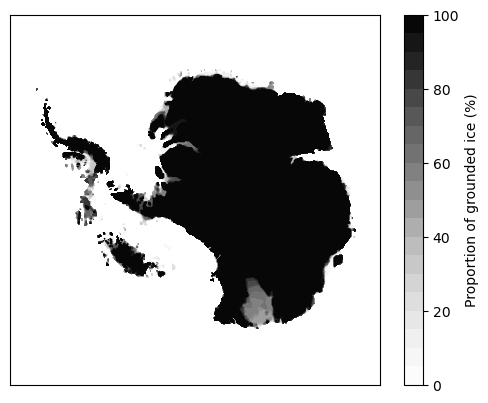

In [6]:
fig, ax = plt.subplots(
    #subplot_kw={'projection': ccrs.SouthPolarStereo()}
    )
kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
im = ax.contourf(x, y, proportion_grounded*100, 20, vmin=0, vmax=100, cmap='Greys', 
                #transform = ccrs.Stereographic(**kw)
                )
#ax.set_axis_off()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
#ax.coastlines(lw=0.2)
fig.colorbar(im, label='Proportion of grounded ice (%)', extend='both', ticks=np.arange(0, 101, 20))

plt.savefig('/Users/jonniebarnsley/Downloads/pliocene_proportion_grounded_ice.png', dpi=300, bbox_inches='tight')

In [7]:
speed_datasets = []
xVelArrays = load('xVel', 9990).values()
yVelArrays = load('yVel', 9990).values()
for xvel, yvel in zip(xVelArrays, yVelArrays):
    speed = np.sqrt(xvel**2 + yvel**2)
    speed_datasets.append(speed)

ensemble_mean_speed = xr.concat(speed_datasets, dim='dummy').mean(dim='dummy')
ensemble_std_speed = xr.concat(speed_datasets, dim='dummy').std(dim='dummy')

Pliocene_run048_cesm_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_xVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run048_cesm_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run064_ccsm4uoft_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run097_hadcm3_yVel_0lev.nc has no time coordinate 9990. continuing...
Pliocene_run108_hadcm3_yVel_0lev.nc has no time coordinate 9990. continuing...


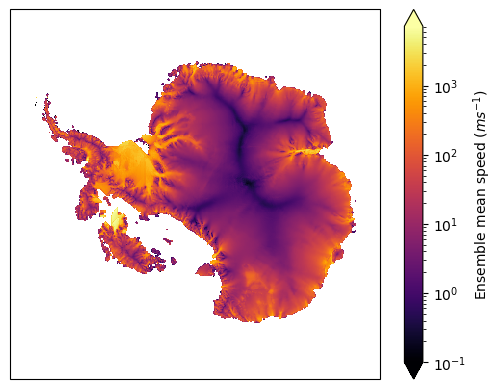

In [9]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
im = ax.pcolormesh(ensemble_mean_speed, cmap='inferno', norm=mpl.colors.LogNorm(vmin=0.1), transform=ccrs.Stereographic(**kw))
ax.coastlines()
#ax.set_axis_off()
ax.set_aspect('equal')
#ax.set_title('BISICLES')
fig.colorbar(im, label='Ensemble mean speed ($ms^{-1}$)', extend='both', ticks=[0.1, 1, 10, 100, 1000])

plt.savefig('/Users/jonniebarnsley/Downloads/pliocene_mean_speed.png', dpi=300, bbox_inches='tight')